# Proyecto Series Temporales
### Grupo 8 - Walmart Sales
#### Integrantes:

- Diego Collado
- Iñigo Gonzalez-Varas
- Carlota Lopez
- Diego Lopez



Este trabajo trata de predecir las ventas semanales de Walmart.

Importamos las librerías necesarias para el trabajo.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
import warnings
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.linear_model import LinearRegression
from sklearn.tree import export_text
from sklearn.tree import plot_tree
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings('ignore')

## Exploración preliminar de los datos

In [2]:
train_set = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv')
test = pd.read_csv('test.csv')
features = pd.read_csv('features.csv')

Train set: 5 columnas
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- Weekly_Sales: ventas semanales (date->date+7)
- IsHoliday: si la semana contiene un dia festivo

In [3]:
train_set.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Stores set: 3 columnas
- Store: número de tienda
- Type: tipo de tienda (se asigna una letra dependiendo del tamaño de la tienda)
- Size: tamaño de la tienda

In [4]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Features set: 12 columnas
- Store: número de tienda
- Date: fecha de inicio de la semana
- Temperature: temperatura media durante la semana en la región donde está ubicada la tienda (Fahrenheit)
- Fuel_Price: precio medio del combustible en la zona donde está ubicada la tienda
- MarkDown1-5: datos anónimos relacionados con promociones. Esta información está disponible solo para algunas tiendas y para algunas fechas.
- CPI: índice de precios al consumo (Consumer Price Index). 
- Unemployment: tasa de desempleo
- IsHoliday: si la semana contiene un dia festivo


In [5]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


Test set: 4 columnas (subconjunto de train)
- Store: número de tienda
- Dept: número de departamento
- Date: fecha de inicio de la semana
- IsHoliday: si la semana contiene un dia festivo


In [6]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## Conclusiones de la exploración preliminar

Con estos datos, vamos a tratar de predecir las ventas semanales de walmart agrupadas por tienda y departamento. 
En primer lugar, desarrollamos un modelo que únicamente tenga como input la serie temporal de ventas e intente prdecir las ventas futuras. 
Una vez veamos cómo funciona este modelo, añadiremos más variables (exógenas) para ver si podemos mejorar la predicción.

## Tratamiento de datos

En primer lugar, vamos a agrupar las ventas por tienda y departamento. Asignamos la fecha como índice del dataframe.

In [7]:
total_sales = train_set.groupby('Date')['Weekly_Sales'].sum().reset_index()
total_sales['Date'] = pd.to_datetime(total_sales['Date'], format='%Y-%m-%d')
total_sales = total_sales.set_index('Date')
total_sales = total_sales.asfreq('W-FRI')

total_sales

,Weekly_Sales
Date,
2010-02-05,49750740.50
2010-02-12,48336677.63
2010-02-19,48276993.78
2010-02-26,43968571.13
2010-03-05,46871470.30
...,...
2012-09-28,43734899.40
2012-10-05,47566639.31
2012-10-12,46128514.25


Observamos cómo queda la serie temporal de ventas semanales

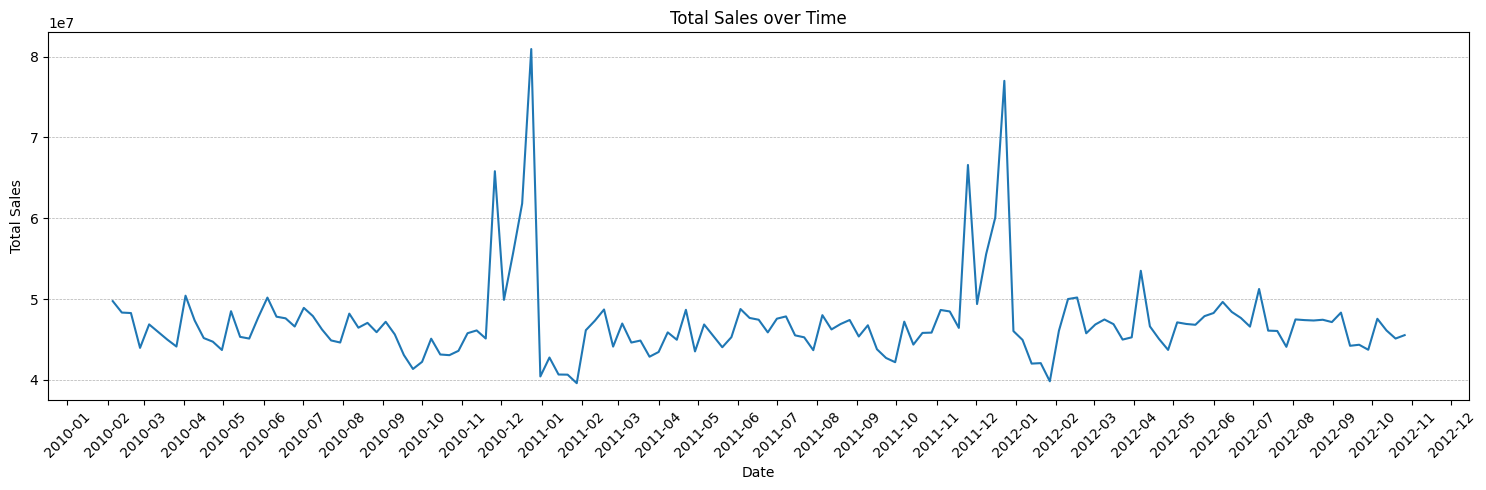

In [8]:
# Plotting the total sales over time
plt.figure(figsize=(15, 5))
plt.plot(total_sales.index, total_sales['Weekly_Sales'])
locator = mdates.MonthLocator()  
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales over Time')
plt.xticks(rotation=45)  # Rotate the x-ticks for better visibility
plt.tight_layout()  # Ensure layout is neat and no labels are cut off
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()

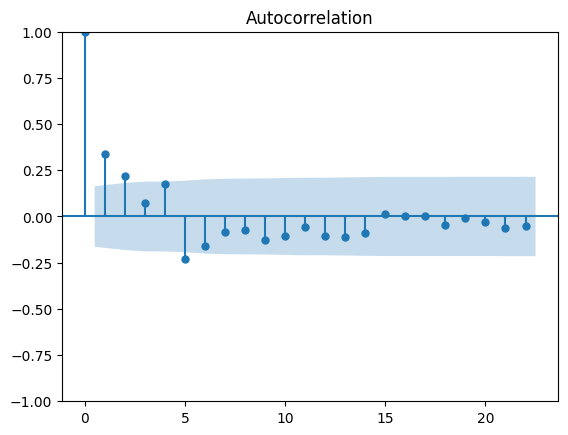

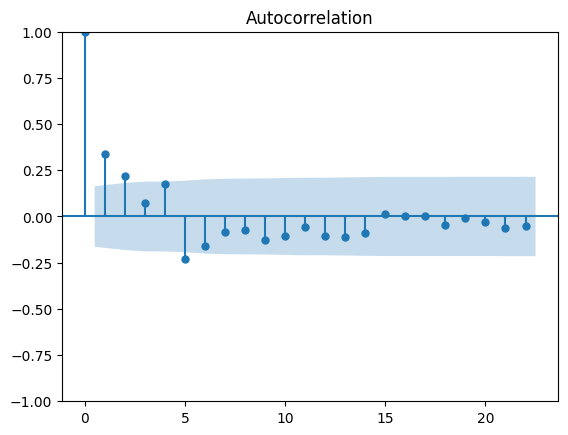

In [9]:
# plotting autocorrelation 
plot_acf(total_sales)

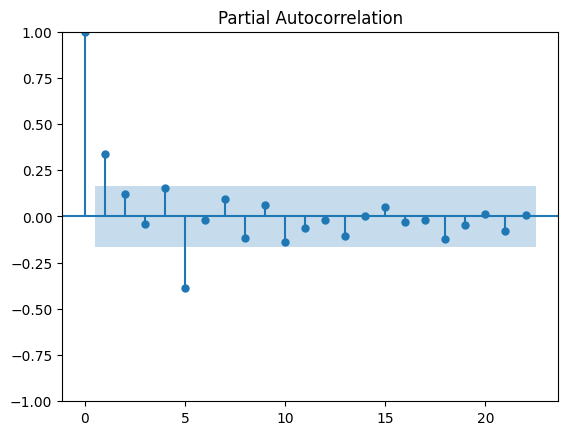

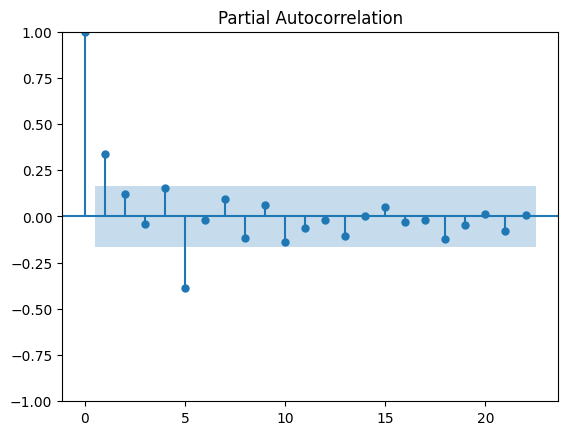

In [10]:
# plotting partial autocorrelation
plot_pacf(total_sales)

Vamos a dividir la serie en train y test. Para ello, vamos a coger el 80% de los datos para train y el 20% para test. Se puede ver la división claramente en la gráfica

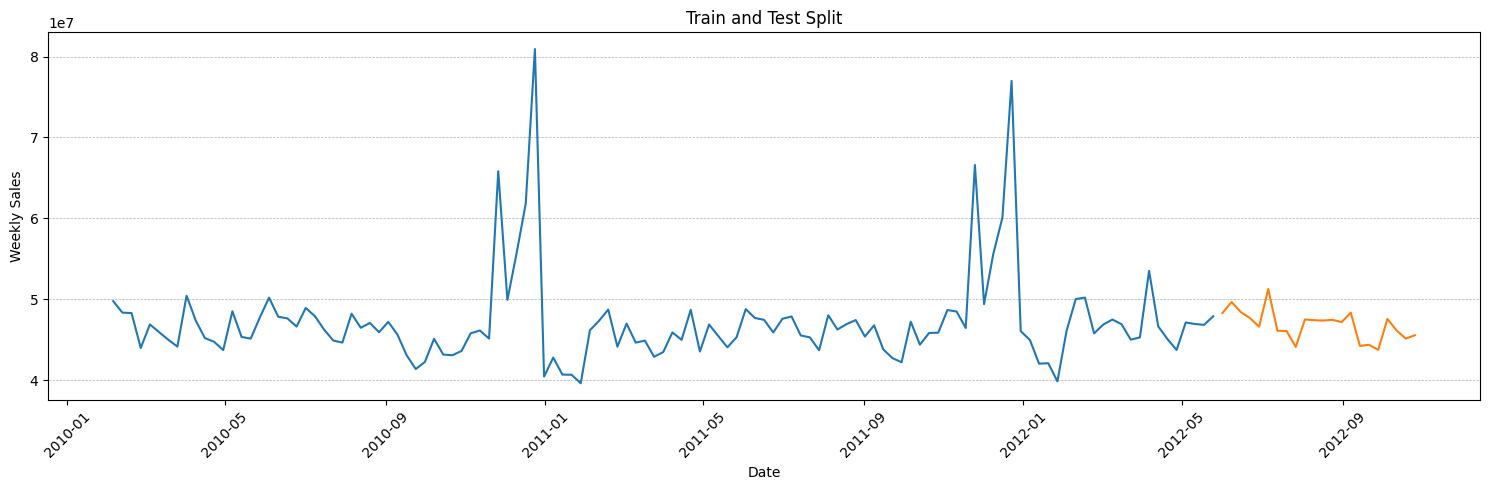

In [11]:
# splitting dataset into train and test set (80:20)
train, test = total_sales.iloc[:int(len(total_sales)*0.85)], total_sales.iloc[int(len(total_sales)*0.85):]
plt.figure(figsize=(15, 5))
plt.plot(train.index, train['Weekly_Sales'])
plt.plot(test.index, test['Weekly_Sales'])
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.title('Train and Test Split')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
plt.show()


Definimos una función para crear los lags de la serie temporal. Así, tendremos un dataset que pueda servir como input de un modelo. 

In [12]:
def create_lag_features(df, lag_columns, max_lag, max_yearly_lag=0):
    temp_df = df.copy()
    
    # Create weekly lag features
    for column in lag_columns:
        for lag in range(1, max_lag + 1):
            temp_df[f'{column}_lag_{lag}'] = temp_df[column].shift(lag)
    
    # Create yearly lag features for same week of previous years and the weeks before that
    for column in lag_columns:
        for year in range(1, max_yearly_lag + 1):
            for lag in range(0, max_lag):  # Starting from 0 to capture the same week from the previous year
                temp_df[f'{column}_year{year}_lag_{lag}'] = temp_df[column].shift(52 * year + lag)
                
    return temp_df

df = create_lag_features(total_sales, ['Weekly_Sales'], 15, max_yearly_lag=0)  # Adjust the parameters as needed
train, test = df.iloc[:int(len(df)*0.85)], df.iloc[int(len(df)*0.85):]
test.dropna(inplace=True)  # Drop the rows with missing values in the test set
train.dropna(inplace=True)
train.head()


,Weekly_Sales,Weekly_Sales_lag_1,Weekly_Sales_lag_2,Weekly_Sales_lag_3,Weekly_Sales_lag_4,Weekly_Sales_lag_5,Weekly_Sales_lag_6,Weekly_Sales_lag_7,Weekly_Sales_lag_8,Weekly_Sales_lag_9,Weekly_Sales_lag_10,Weekly_Sales_lag_11,Weekly_Sales_lag_12,Weekly_Sales_lag_13,Weekly_Sales_lag_14,Weekly_Sales_lag_15
Date,,,,,,,,,,,,,,,,
2010-05-21,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63,49750740.50
2010-05-28,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78,48336677.63
2010-06-04,50188543.12,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13,48276993.78
2010-06-11,47826546.72,50188543.12,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30,43968571.13
2010-06-18,47622046.23,47826546.72,50188543.12,47757502.56,45120108.06,45330080.20,48503243.52,43705126.71,44734452.56,45183667.08,47365290.44,50423831.26,44133961.05,44988974.64,45925396.51,46871470.30


<AxesSubplot: xlabel='y(t)', ylabel='y(t + 1)'>

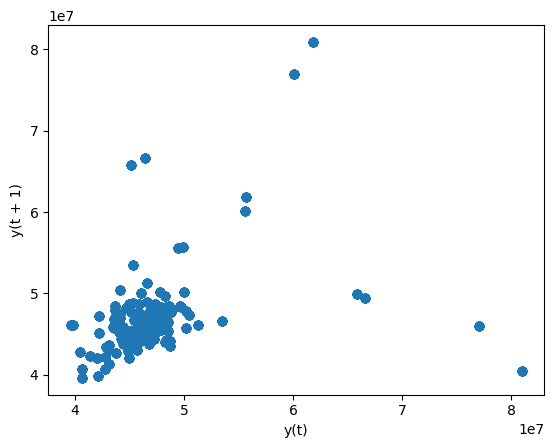

In [13]:
lag_plot(df)

### SARIMAX

In [37]:
order = (2, 1, 1) 
# el primer componente es el orden de autorregresión (número de términos autorregresivos en el modelo)
# el segundo componente es el orden de diferenciación (cuántas veces se diferencia la serie temporal para hacerla estacionaria)
# el tercer componente es el orden de media móvil (número de términos de media móvil en el modelo)

seasonal_order = (2, 1, 1, 52)
# el primer componente es el orden de autorregresión estacional (número de términos autorregresivos estacionales en el modelo)
# el segundo componente es el orden de diferenciación estacional (cuántas veces se diferencia la serie temporal para hacerla estacionaria)
# el tercer componente es el orden de media móvil estacional (número de términos de media móvil estacional en el modelo)
# el cuarto componente es la periodicidad estacional (cuántos períodos de tiempo hay en una temporada)

# Build and fit the SARIMAX
train, test = total_sales.iloc[:int(len(total_sales)*0.85)], total_sales.iloc[int(len(total_sales)*0.85):]
model = SARIMAX(endog = train, order = order, seasonal_order = seasonal_order)
results = model.fit() 
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                       Weekly_Sales   No. Observations:                  121
Model:             SARIMAX(2, 1, 1)x(2, 1, 1, 52)   Log Likelihood               -1085.937
Date:                            Sun, 08 Oct 2023   AIC                           2185.875
Time:                                    16:13:15   BIC                           2201.411
Sample:                                02-05-2010   HQIC                          2192.031
                                     - 05-25-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1226      1.783     -0.069      0.945      -3.618       3.373
ar.L2         -0.0682      0.205   

Cosas que se pueden decir de esto:
- el log likelihood cuanto mas cerca de 0 mejor (es demasiado baja asi que el modelo no se ajusta muy bien a los datos)
- AIC y BIC cuanto mas bajo mejor (son muy altos -> modelo demasiado complejo)
- coef de sigma2 muy alto es porque los residuos no estan bien modelados -> variabilidad inusual de los datos
- se pueden poner variables exogenas con: exog = features['Fuel_Price'] pero los resultados no cambian

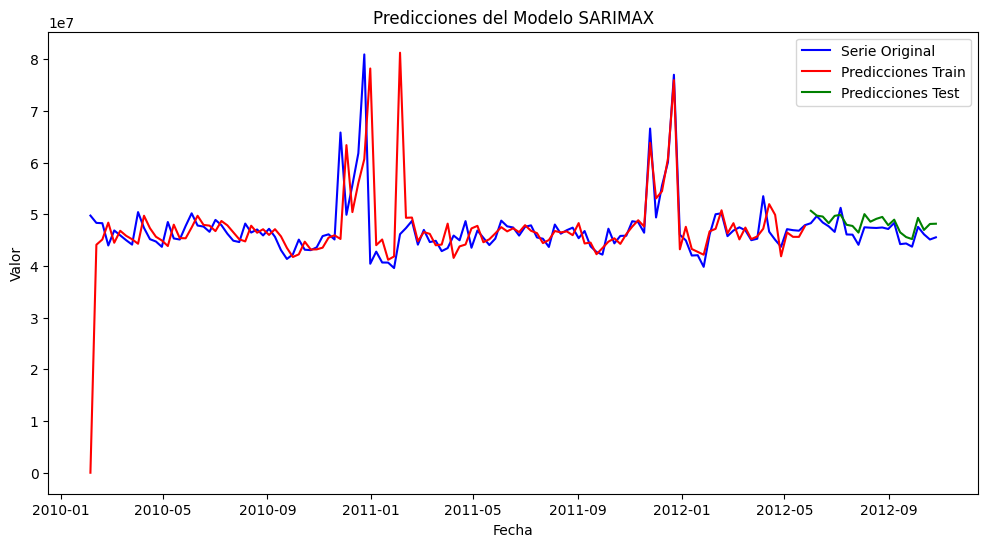

In [42]:
predicciones_train = results.get_prediction(start = 0, end = len(train)-1)
predicciones_test = results.get_prediction(start = len(train), end = len(train) + len(test) - 1)
 
predicciones_train_valores = predicciones_train.predicted_mean
predicciones_test_valores = predicciones_test.predicted_mean

plt.figure(figsize=(12, 6))
plt.plot(total_sales, label='Serie Original', color='blue')
plt.plot(predicciones_train_valores.index, predicciones_train_valores, label='Predicciones Train', color='red')
plt.plot(predicciones_test_valores.index, predicciones_test_valores, label='Predicciones Test', color='green')
plt.legend()
plt.title('Predicciones del Modelo SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.show()

In [43]:
mse_train = mean_squared_error(train, predicciones_train_valores)
mse_test = mean_squared_error(test, predicciones_test_valores)

print(f'MSE en train: {mse_train}')
print(f'MSE en test: {mse_test}')


MSE en train: 55715855680542.69
MSE en test: 3432136952066.4043


## Entrenamiento del modelo

El primer modelo que vamos a entrenar es un Decision Tree Regressor, ya que fue el primer modelo utilizado en clase. Dividimos nuestros datos en de train y test en datos de entrada (X) y datos de salida (y). Definimos el modelo, lo entrenamos y hacemos la predicción.

### Decision Tree Regressor

In [ ]:
X_train = train.drop('Weekly_Sales', axis=1)
y_train = train['Weekly_Sales']
X_test = test.drop('Weekly_Sales', axis=1)
y_test = test['Weekly_Sales']
# Crear y entrenar el modelo de árbol de decisión
modelo_arbol = DecisionTreeRegressor(max_depth=10, random_state=42)
modelo_arbol.fit(X_train, y_train)
predicciones_tree = modelo_arbol.predict(X_test)
err_tree = mean_squared_error(y_test, predicciones_tree)
print(err_tree)

6438019290281.19


Una vez predicho, comparamos los resultados con los datos de test. Para ello, creamos una gráfica con los datos de test y los datos predichos por el modelo.

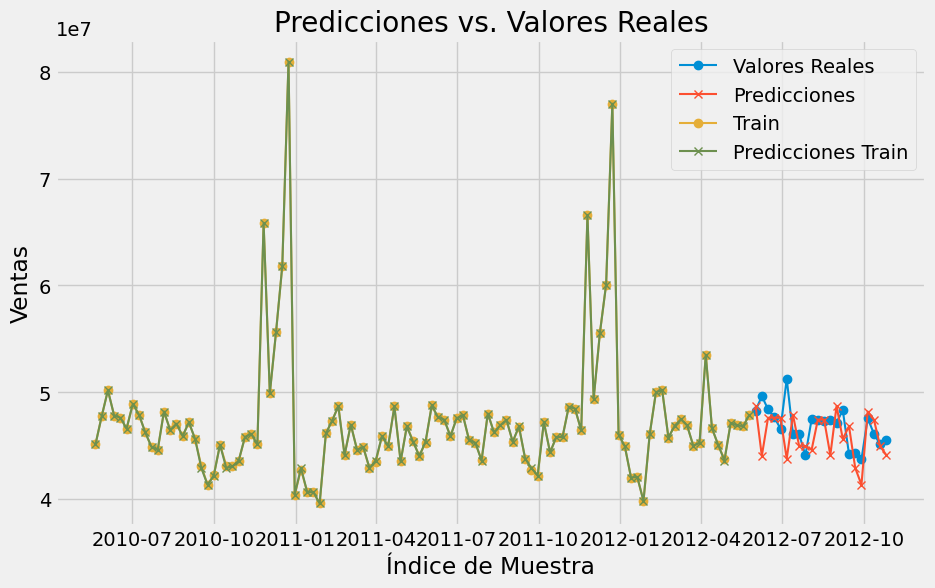

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(y_test.index,y_test, label='Valores Reales', marker='o')
plt.plot(y_test.index,predicciones_tree, label='Predicciones', marker='x')
plt.plot(y_train.index,y_train, label='Train', marker='o')
plt.plot(y_train.index,modelo_arbol.predict(X_train), label='Predicciones Train', marker='x')
plt.xlabel('Índice de Muestra')
plt.ylabel('Ventas')
plt.title('Predicciones vs. Valores Reales')
plt.legend()
plt.show()

### Forecaster

El segundo modelo que vamos a entrenar es un Forecaster de skforecast que utilice regresión lineal y 15 lags. Después de entrenarlo, hacemos la predicción y comparamos los resultados con los datos de test.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = LinearRegression(),
                    lags = 15
             )

forecaster.fit(y=train['Weekly_Sales'])

# Intervalos de predicción
# ==============================================================================
predicciones = forecaster.predict_interval(
                    steps    = len(y_test)
               )
predicciones = predicciones.set_index(y_test.index)
predicciones.head(5)

err_forecast = mean_squared_error(y_test, predicciones['pred'])
if err_forecast > err_tree:
    print("El error del modelo de arbol es menor que el error del modelo de regresion")
else: 
     print("El error del modelo de arbol es mayor que el error del modelo de regresion")
print(f'Err Tree: {err_tree} Err Forecast: {err_forecast}')
print(f'err_forecast/err_tree: {err_forecast/err_tree}')

El error del modelo de arbol es mayor que el error del modelo de regresion
Err Tree: 6438019290281.19 Err Forecast: 3759535901008.714
err_forecast/err_tree: 0.5839584709980746


Hacemos una gráfica con los valores reales y los predichos, así como los intervalos de confianza.

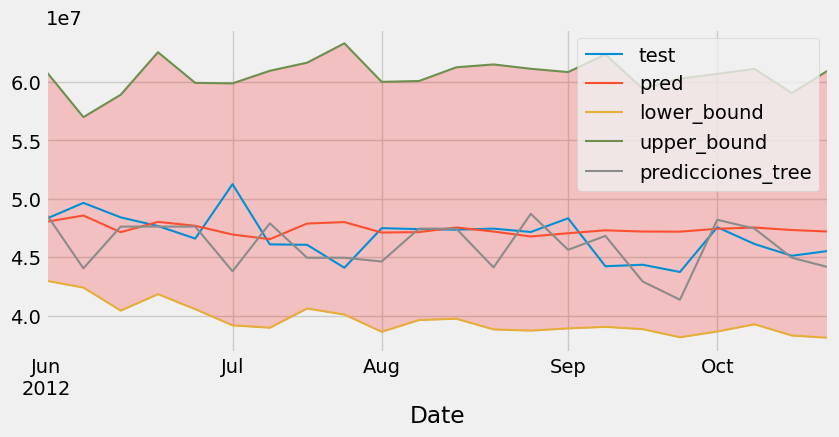

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
y_test.plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
predicciones_tree = pd.Series(predicciones_tree, index=y_test.index)
predicciones_tree.plot(ax=ax, label='predicciones_tree')
ax.fill_between(
    y_test.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

# EXPERIMENTO 2

Una vez vistos los dos primeros modelos mas basicos vamos a profundizar un poco mas para imtentar mejorar los resultados

In [ ]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

Primero vamos a entrenar un random forest, sin indagar en los parametros

## RANDOM FOREST BASICO

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                    regressor = RandomForestRegressor(random_state=123),
                    lags = 15
             )

forecaster.fit(y=train['Weekly_Sales'])
forecaster
# Intervalos de predicción
# ==============================================================================


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Window size: 15 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-05-21 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-07 13:01:39 
Last fit date: 2023-10-07 13:01:40 
Skforec

In [ ]:
predicciones = forecaster.predict(
                    steps    = len(y_test)
               )

predicciones.head(5)



2012-06-01    4.740954e+07
2012-06-08    4.669666e+07
2012-06-15    4.552296e+07
2012-06-22    4.471817e+07
2012-06-29    4.485507e+07
Freq: W-FRI, Name: pred, dtype: float64

In [ ]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')


Err Forecast: 3897588564547.2583


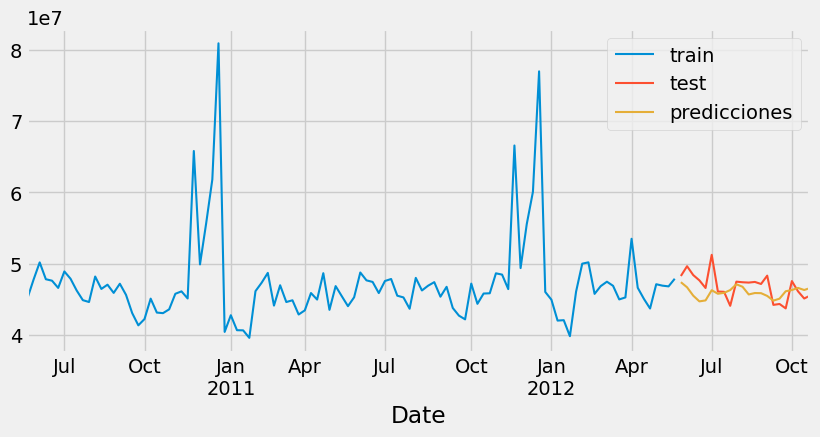

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

Con la configuracion base comprobamos que el resultado mejora por lo que vamos a hacer un gridsearch a ver si lo mejoramos aun más

## RANDOM FOREST GRID

In [ ]:
steps = len(y_test)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20, 40]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_estimators': [20, 50, 100, 200],
              'max_depth': [50, 100, 200, 500]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Weekly_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 50, 'n_estimators': 20}
  Backtesting metric: 19266712559790.066



In [ ]:
predicciones = forecaster.predict(steps=len(y_test))

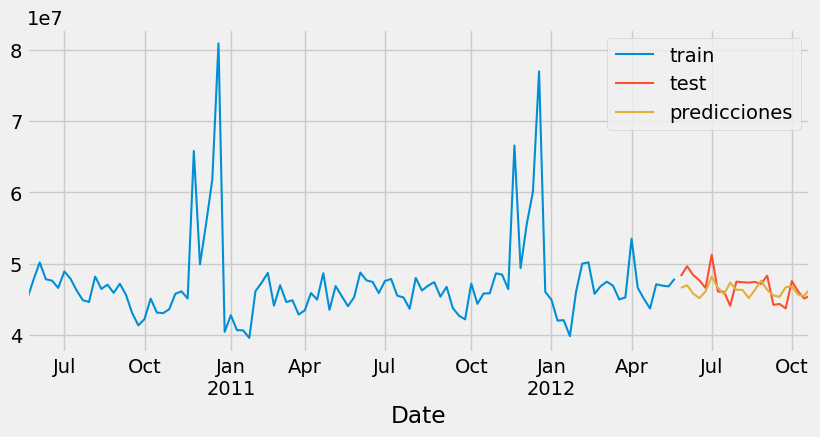

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [ ]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 3160673726723.7324


Los resultados son mejores vamos a porbar con KNN y lasso, perimero sin grid search, veremos cual de los dos es mejor y haremos un grid con el mejor para ver si los resultados son mejores

## KNN BASICO

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(),
                lags = 6
             )

forecaster.fit(y=train['Weekly_Sales']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: KNeighborsRegressor() 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-05-21 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'} 
fit_kwargs: {} 
Creation date: 2023-10-07 13:02:11 
Last fit date: 2023-10-07 13:02:11 
Skforecast version: 0.10.1 
Python version: 3.10.7 
Forecaster id: None 

In [ ]:
predicciones = forecaster.predict(steps=len(y_test))

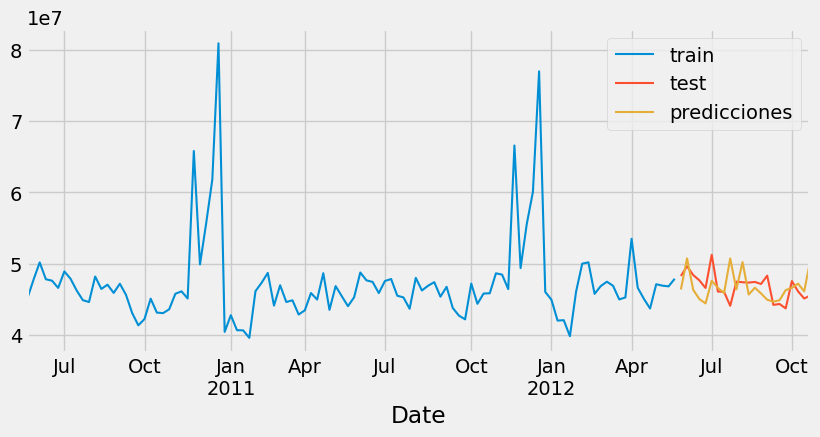

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [ ]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 6325494074040.564


Vamos a probar con el lasso

## LASSO BASICO

In [ ]:
from sklearn import linear_model
forecaster = ForecasterAutoreg(                
                regressor = linear_model.Lasso(alpha=0.1),
                lags = 6
             )

forecaster.fit(y=train['Weekly_Sales']) # cambiar el nombre de la variable objetivo
forecaster

ForecasterAutoreg 
Regressor: Lasso(alpha=0.1) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2010-05-21 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000, 'normalize': 'deprecated', 'positive': False, 'precompute': False, 'random_state': None, 'selection': 'cyclic', 'tol': 0.0001, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-07 13:02:11 
Last fit date: 2023-10-07 13:02:11 
Skforecast version: 0.10.1 
Python version: 3.10.7 
Forecaster id: None 

In [ ]:
predicciones = forecaster.predict(steps=len(y_test))

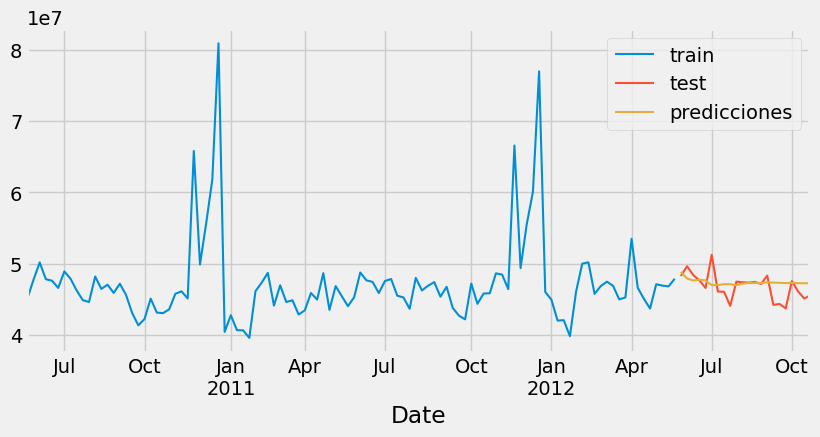

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [ ]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 3439178472293.64


El modelo lasso es el que mejor se adapta a la tendencia pero no predice los picos demasiado bien, vamos a hacer un gridsearch a ver si mejora

## LASSO GRID

In [ ]:
steps = len(y_test)
forecaster = ForecasterAutoreg(
                regressor = linear_model.Lasso(alpha=0.1),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 10, 20, 40]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'max_iter': [500, 1000, 2000, 5000],
              'alpha':[0.005, 0.007, 0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.024, 0.025, 0.026, 0.03],
              
              }

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Weekly_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 192.


lags grid:   0%|          | 0/4 [00:00<?, ?it/s]

params grid:   0%|          | 0/48 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'alpha': 0.007, 'max_iter': 5000}
  Backtesting metric: 33834143983316.34



In [ ]:
predicciones = forecaster.predict(steps=len(y_test))

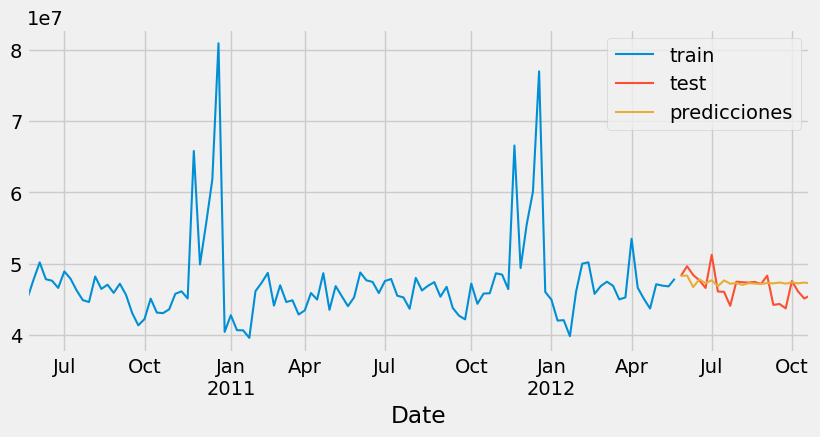

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();

In [ ]:
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

Err Forecast: 3239796947451.1016


## KNN GRID

In [ ]:
steps = len(y_test)
forecaster = ForecasterAutoreg(
                regressor = KNeighborsRegressor(),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [5, 10, 20]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
              'weights': ['uniform', 'distance'],
              
              }

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train['Weekly_Sales'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 90.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/30 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'n_neighbors': 6, 'weights': 'distance'}
  Backtesting metric: 34999922957407.766



In [ ]:
predicciones = forecaster.predict(steps=len(y_test))

Err Forecast: 9378426027681.295


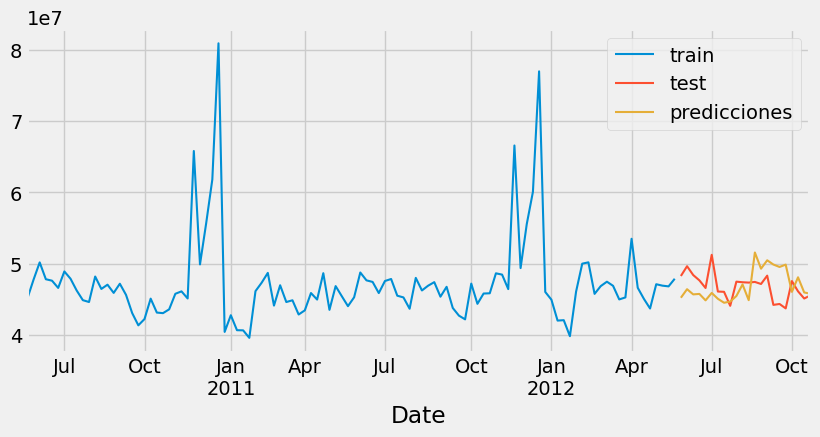

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')

ax.legend();
err_forecast = mean_squared_error(y_test, predicciones)

print(f'Err Forecast: {err_forecast}')

## BACKTESTING

In [ ]:
steps = len(y_test)
n_backtesting = steps  

metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = total_sales['Weekly_Sales'],
                                    initial_train_size = len(total_sales) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metrica}")

Information of backtesting process
----------------------------------
Number of observations used for initial training: 121
Number of observations used for backtesting: 22
    Number of folds: 1
    Number of steps per fold: 22
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   2010-02-05 00:00:00 -- 2012-05-25 00:00:00  (n=121)
    Validation: 2012-06-01 00:00:00 -- 2012-10-26 00:00:00  (n=22)



  0%|          | 0/1 [00:00<?, ?it/s]

Error de backtest: 11333792189385.146


Err Forecast: 11333792189385.146


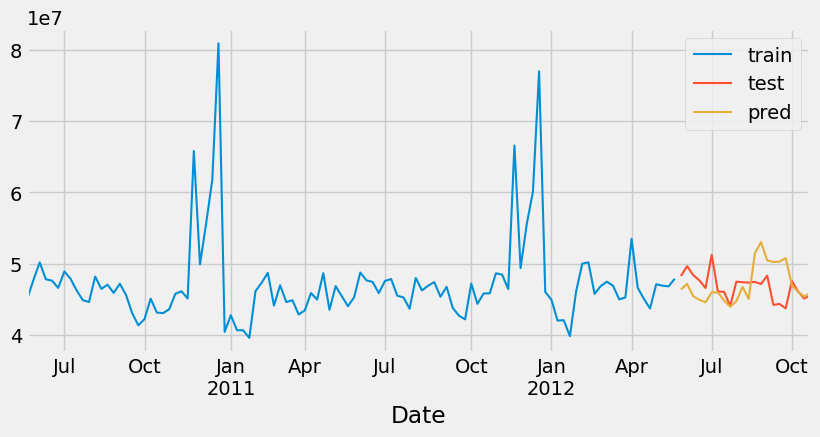

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
train['Weekly_Sales'].plot(ax=ax, label='train')
test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
err_forecast = mean_squared_error(y_test, predicciones_backtest)

print(f'Err Forecast: {err_forecast}')
ax.legend();


## AHORA VARIABLES EXOGENAS

### primero añadir las variables a nuestro df

In [ ]:
df = train_set.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
df.drop(['IsHoliday_y'], axis=1,inplace=True) 
df.rename(columns={'IsHoliday_x':'IsHoliday'},inplace=True)
df.loc[df['Weekly_Sales']<=0]
df = df.loc[df['Weekly_Sales'] > 0]
df = df.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Size','Type'], axis=1)
df_agrupado = df.groupby('Date').agg({'Weekly_Sales': 'sum'}).reset_index()
df_agrupado = df_agrupado.merge(df.drop('Weekly_Sales', axis=1), on=['Date'], how='inner')
df_agrupado.drop('Dept', axis=1, inplace=True)
df_agrupado.drop('Store', axis=1, inplace=True)
df_sin_duplicados = df_agrupado.drop_duplicates(subset=['Weekly_Sales'])
df_sin_duplicados =df_sin_duplicados.reset_index(drop=  True)
df_sin_duplicados

,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
0,2010-02-05,49750875.98,False,42.31,2.572,211.096358,8.106
1,2010-02-12,48336800.10,True,38.51,2.548,211.242170,8.106
2,2010-02-19,48277902.33,False,39.93,2.514,211.289143,8.106
3,2010-02-26,43970440.65,False,46.63,2.561,211.319643,8.106
4,2010-03-05,46872715.16,False,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...
138,2012-09-28,43735713.56,False,76.08,3.666,222.981658,6.908
139,2012-10-05,47567053.49,False,68.55,3.617,223.181477,6.573
140,2012-10-12,46128909.98,False,62.99,3.601,223.381296,6.573
141,2012-10-19,45122443.96,False,67.97,3.594,223.425723,6.573


In [ ]:
df_sin_duplicados['Date'] = pd.to_datetime(df_sin_duplicados['Date'], format='%Y-%m-%d')
df_sin_duplicados = df_sin_duplicados.set_index('Date')
df_sin_duplicados = df_sin_duplicados.asfreq('W-FRI')


In [ ]:
dfexog = df_sin_duplicados.copy()
dfexog['IsHoliday'] = dfexog['IsHoliday'].astype(int)
dfexog

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,CPI,Unemployment
Date,,,,,,
2010-02-05,49750875.98,0,42.31,2.572,211.096358,8.106
2010-02-12,48336800.10,1,38.51,2.548,211.242170,8.106
2010-02-19,48277902.33,0,39.93,2.514,211.289143,8.106
2010-02-26,43970440.65,0,46.63,2.561,211.319643,8.106
2010-03-05,46872715.16,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...
2012-09-28,43735713.56,0,76.08,3.666,222.981658,6.908
2012-10-05,47567053.49,0,68.55,3.617,223.181477,6.573
2012-10-12,46128909.98,0,62.99,3.601,223.381296,6.573


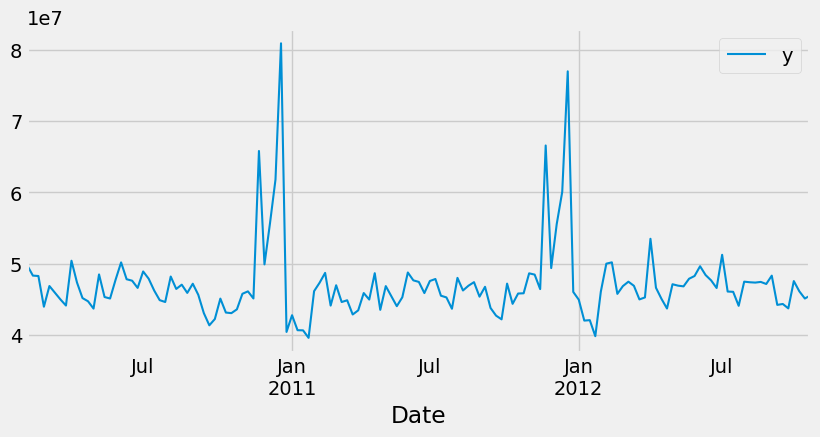

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
dfexog['Weekly_Sales'].plot(ax=ax, label='y')
#dfexog['IsHoliday'].plot(ax=ax, label='variable exógena')
ax.legend();

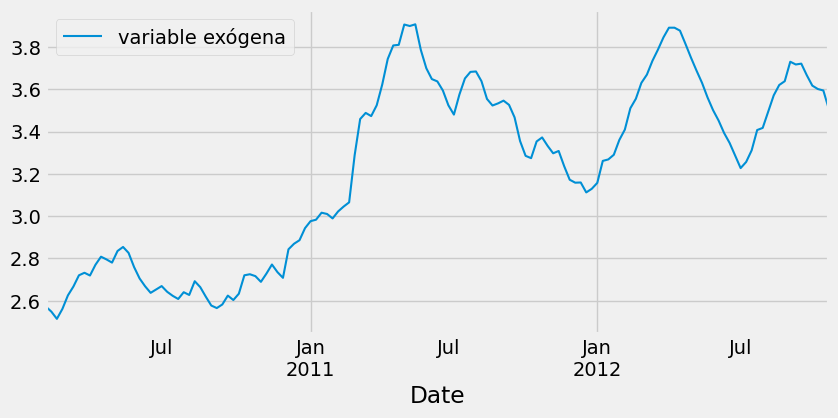

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
#dfexog['Weekly_Sales'].plot(ax=ax, label='y')
dfexog['Fuel_Price'].plot(ax=ax, label='variable exógena')
ax.legend();

In [ ]:
steps = len(y_test)
datos_train = dfexog[:-steps]
datos_test  = dfexog[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 2010-02-05 00:00:00 --- 2012-05-25 00:00:00  (n=121)
Fechas test  : 2012-06-01 00:00:00 --- 2012-10-26 00:00:00  (n=22)


## Hacemos el rfr con los mejores datos de antes

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(max_depth= 50, n_estimators = 20),
                lags      = 10
             )

forecaster.fit(y=datos_train['Weekly_Sales'], exog=datos_train['Fuel_Price'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=50, n_estimators=20) 
Lags: [ 1  2  3  4  5  6  7  8  9 10] 
Transformer for y: None 
Transformer for exog: None 
Window size: 10 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Type of exogenous variable: <class 'pandas.core.series.Series'> 
Exogenous variables names: Fuel_Price 
Training range: [Timestamp('2010-02-05 00:00:00'), Timestamp('2012-05-25 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: W-FRI 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 50, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 20, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2023-10-07 13:02:25 
Last fit da

In [ ]:
predicciones = forecaster.predict(steps=steps, exog=datos_test['Fuel_Price'])

Err Forecast: 4810010818034.772


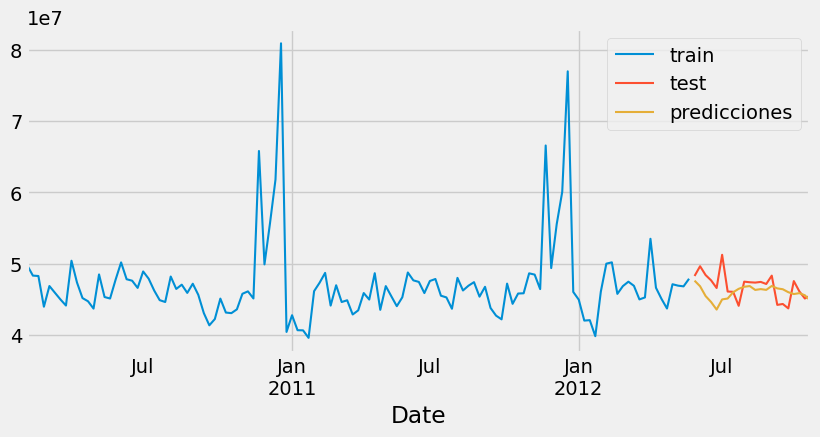

In [ ]:
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['Weekly_Sales'].plot(ax=ax, label='train')
datos_test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
err_forecast = mean_squared_error(datos_test['Weekly_Sales'], predicciones)

print(f'Err Forecast: {err_forecast}')
ax.legend();

## RFR GRID

In [ ]:
steps = len(datos_test)
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(),
                lags      = 6 # Este valor será remplazado en el grid search
             )

# Lags utilizados como predictores
lags_grid = [10, 20, 40]

# Hiperparámetros del regresor
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

param_grid = {'n_estimators': [20, 50, 100, 200],
              'max_depth': [50, 100, 200, 500]}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['Weekly_Sales'],
                        exog               = datos_train['Fuel_Price'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                   )

Number of models compared: 48.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/16 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 200, 'n_estimators': 20}
  Backtesting metric: 35123204771964.465



In [ ]:
predicciones = forecaster.predict(steps=steps, exog=datos_test['Fuel_Price'])


Err Forecast: 2912698373144.519


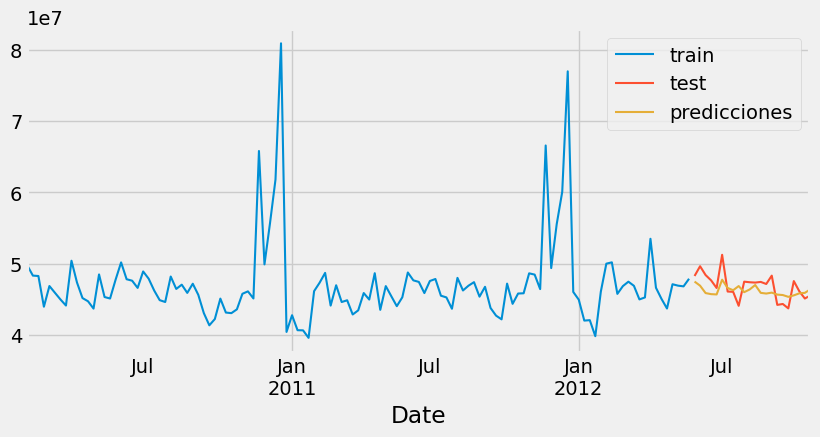

In [ ]:
fig, ax=plt.subplots(figsize=(9, 4))
datos_train['Weekly_Sales'].plot(ax=ax, label='train')
datos_test['Weekly_Sales'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
err_forecast = mean_squared_error(datos_test['Weekly_Sales'], predicciones)

print(f'Err Forecast: {err_forecast}')
ax.legend();